In [1]:
%run ../src/shipproject/imports.py

2021-07-12 15:01:37.955389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-12 15:01:37.955417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


imports added!


In [2]:
# ships/shipProject/notebooks/ships1.ipynb
!pwd

/home/buffbob/dev/Notebooks/ships/shipProject/notebooks


In [3]:
from shipproject.ships_utils import *
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%time d, df = getData()

CPU times: user 6.66 s, sys: 318 ms, total: 6.98 s
Wall time: 6.97 s


In [6]:
%%time
x = np.array(d['data']).astype('uint8')
y = np.array(d['labels']).astype('uint8')


CPU times: user 3.72 s, sys: 159 ms, total: 3.88 s
Wall time: 3.86 s


In [7]:
describeData(x,y)

Total number of images: 4000
Number of NoShip Images: 3000
Number of Ship Images: 1000
Percentage of positive images: 25.00%
Image shape (Width, Height, Channels): (19200,)


In [8]:
print(x.shape)
xx, yy = reshape(x,y)
print(xx.shape)

(4000, 19200)
(4000, 80, 80, 3)


In [9]:
shipImages = xx[y==1]
notShipImages = xx[y==0]

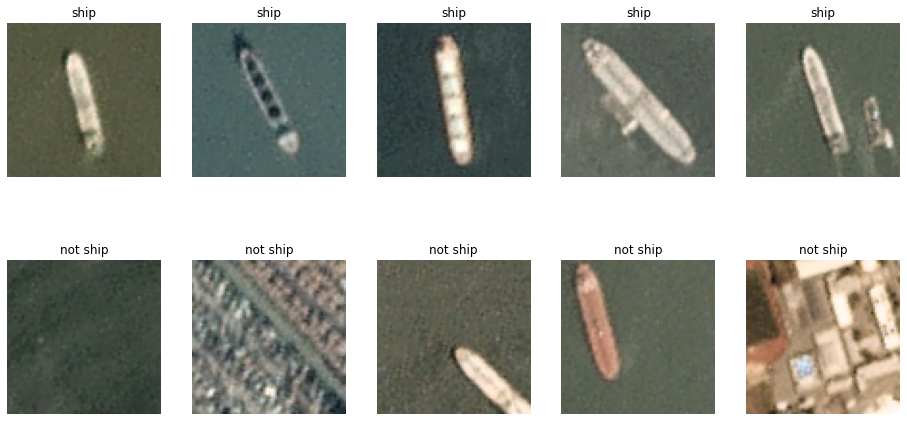

In [10]:
showRandomImages(shipImages, notShipImages)

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.5)
])


In [ ]:
test_augmentation(data_augmentation, shipImages,row=2, col=5)

In [ ]:
plt.imshow(shipImages[202])

In [ ]:
# HOW to apply custom aug 
def random_invert_img(x, p=0.5):
    rand = np.random.random()
    if  rand < p:
        x = (1-x)
        
    return x, rand

In [ ]:
plt.figure(figsize=(20,10))
for i in range (18):
    ii, rand = random_invert_img(image)
    plt.subplot(3,6,i+1)
    plt.imshow(ii)
    plt.title("%.2f" % rand)
    plt.axis('off')
    

In [ ]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

## using tf.image for more control

In [ ]:
flipped = tf.image.flip_left_right(image)

In [ ]:
visualize(image, flipped)

In [ ]:
visualize(image, tf.squeeze(tf.image.rgb_to_grayscale(image)))
plt.colorbar()

In [ ]:
factor = (np.random.random()*5/10)
visualize(image, tf.image.adjust_brightness(image, factor))
print(factor)

In [ ]:
visualize(image, tf.image.stateless_random_contrast(image, lower=.2, upper=.8, seed=(3,0)))

trying to use the stateless examples with the random seed generator, not happy

In [ ]:
SIZE = 80
image_size = (SIZE, SIZE)
def resize_rescale(image, label):
    i = tf.cast(image, tf.float32)
    i = tf.image.resize(image, image_size)
    i = i/255
    return i, label
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_rescale(image, label)
      # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
          # Make a new seed
    new_seed2 = tf.random.experimental.stateless_split(seed, num=12)[0, :]
      # Random contrast
    image = tf.image.stateless_random_contrast(image, lower=0, upper=1, seed=new_seed2)    
      # RandomFlip
    image = tf.image.stateless_random_flip_left_right(image, seed)
      #Random Rotate
    image = tf.image.stateless_random_flip_up_down(image, new_seed)
#       # Random brightness
#     image = tf.image.stateless_random_brightness(
#           image, max_delta=0.5, seed=seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


In [ ]:
i = iter(train_dataset)

In [ ]:
image, label = next(i)

In [ ]:
plt.imshow(image)
plt.title("ship" if label.numpy()==1 else "no ship");

Create a tf.random.Generator object with an intial seed value. Calling make_seeds function on the same generator object returns a new, unique seed value always. Define a wrapper function that 1) calls make_seeds function and that 2) passes the newly generated seed value into the augment function for random transformations.

In [ ]:
i,l = wrapper(image, label)

In [ ]:
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
def wrapper(x,y):
    seed = rng.make_seeds(2)[0]
    i, l = augment((x,y), seed)
    return (i, l)

In [ ]:
plt.figure(figsize=(20,10))
for i in range(18):
    plt.subplot(3,6, i+1)
    i, l = wrapper(image,label)
    plt.imshow(i)
    plt.title("ship" if l.numpy()==1 else "no ship");
print(np.max(i))    